# Python data analysis script Version 1.0

This script takes `.json` files exported from the `[JSONWriter]` module of Corryvreckan, and is aimed towards analyzing and plotting the hit data.

## Importing data into python

### Reading in .json file

In [1]:
import json
import os

file = 'data/example.json'

with open(file) as json_file:
    data = json.load(json_file)

### Writing all relevant data into one object

The goal of this section is to create a python object that contains all necessary data of all events. It should be able to be appended further down the line. The easiest way to do this is to use python lists and dictonaries.

In [2]:
hit_data = []    #initialize the list of all events
event_no = 0     #use a counter that will be incremented on each step

#Start the event loop
for event in data:
    
    #Skip over empty events
    if len(event) == 0:
        print("Event {} empty, skipped".format(event_no))
        continue
        
    #Create a python dictionary for each event.
    hit_data.append({})
    
    #Create an entry in the dictionary for each plane
    for plane in range(7):
        hit_data[event_no][plane] = {}      #Stores all plane data
        hit_data[event_no][plane]["X"] = [] #Stores x-coordinates of hits
        hit_data[event_no][plane]["Y"] = [] #Stores y-coordinates of hits
    
    #Read out pixel by pixel
    for obj in event:
        
        #First, find out which plane the hit belongs to
        plane = int(obj["m_detectorID"].split("_")[1])
        hit_data[event_no][plane]["X"].append(int(obj["m_column"]))
        hit_data[event_no][plane]["Y"].append(int(obj["m_row"]))
        
    #Increment counter
    event_no+=1

Event 0 empty, skipped
Event 87375 empty, skipped


### Adding some helpful information

For later analysis, it can come in handy, to seperate the events into different categories, based on the number of planes that have been hit. So we'll quickly add an entry for that.

In [3]:
for event in range(len(hit_data)):
    
    total_planes = 7 #Set the total number of planes
    
    for plane in range(total_planes):
        if not hit_data[event][plane]["X"]:        #for each empty event
            hit_data[event][plane]["X"].append(-1) #write a -1 into the hit array
            hit_data[event][plane]["Y"].append(-1) #---"---
            total_planes-=1                        #and substract one from the total number of planes
            
    #Add an entry into the dictionary
    hit_data[event]["number_of_planes"] = total_planes
    

This way, we can add all sort of stuff into the dictionary as we go on, from tracking information, all the way to residuals and goodness-of-fit information.

## Calculating hit positions

For now, our data consisted of individual pixel hits. In the next step, we want to combine these hits into a cluster, to determine the
hit position more accurately

In [4]:
import numpy as np
from tqdm import tqdm

counter, bad_counter = 0,0

#Add a cool status bar
with tqdm(total=len(hit_data)) as pbar:

    for event in range(len(hit_data)):
    
        for plane in range(7):
        
            #Calculate the cluster position in X and Y
            Cluster_X = np.mean(hit_data[event][plane]["X"])
            Cluster_Y = np.mean(hit_data[event][plane]["Y"])
        
            #Calculate the standard deviation (the cluster spread)
            sdev = np.sqrt(np.std(hit_data[event][plane]["X"])**2+
                      np.std(hit_data[event][plane]["Y"])**2)
        
            #If the cluster consists of one pixel alone, the uncertainty is defined by
            if sdev == 0: sdev = 1/np.sqrt(12)
            
            #Round values a little bit
            sdev = np.round(sdev,2)
            Cluster_X = np.round(Cluster_X,2)
            Cluster_Y = np.round(Cluster_Y,2)
        
            #Add an entry to the dictionary
            hit_data[event][plane]["XC"] = Cluster_X
            hit_data[event][plane]["YC"] = Cluster_Y
            hit_data[event][plane]["sdev"] = sdev
                
        pbar.update(1)
                

100%|██████████| 87375/87375 [02:28<00:00, 586.74it/s]


## Taking a first look at the data

We will be using the `mplot3d` toolkit from `matplotlib` to visualize the data. First we import it:

In [5]:
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
from mpl_toolkits.mplot3d import proj3d

Next we choose what data to plot, and how we want it to look like

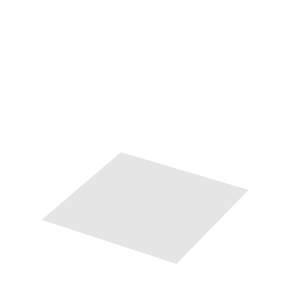

In [16]:
plot_tracks = range(3) #Plot the first 3 events
connect_hits = True    #Connects the hits
min_nop = 7            #Plot only events that include 7 planes

#Create a figure object
xlim,ylim,zlim = 1023*29.24e-3,511*26.88e-3,6*20
fig = plt.figure(figsize=(5,5))
ax = plt.axes(projection='3d')  #Create 3d Axes
ax._axis3don = False            #... but invisible
ax.set_box_aspect((3,3,3))      #Define aspect ratio
ax.set_xlim3d(0,xlim)           #Axis limits in x
ax.set_ylim3d(0,ylim)           #Axis limits in y
ax.set_zlim3d(0,zlim)     
x = np.arange(0,1025*0.02924,512*0.02924)
y = np.arange(0,1024*0.02688,512*0.02688)
X, Y = np.meshgrid(x,y)
Z = np.ndarray((len(y),len(x)))
Z.fill(0)

#Draw the planes
for plane in range(7):
    Z.fill(plane*20000)
    ax.plot_surface(X,Y,Z,alpha=.1,color='black')

plt.show()